# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [319]:
#!pip install comet_ml

In [320]:
from comet_ml import Experiment

In [321]:
#@title CometML set up
project_name = 'predict-income'
workspace = 'flint'
api_key = 'ROXvPHdVV7aywYaR2JjvrBHzp'

In [322]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : salmon_pole_1861
COMET INFO:     url                   : https://www.comet.com/flint/predict-income/1c94550479e145eba668dbaa5810aba1
COMET INFO:   Metrics:
COMET INFO:     Accuracy OneHot data : 0.8500184252548827
COMET INFO:   Parameters:
COMET INFO:     C                     : 1.0
COMET INFO:     categories            : auto
COMET INFO:     class_weight          : None
COMET INFO:     drop                  : None
COMET INFO:     dtype                 : <class 'numpy.float64'>
COMET INFO:     dual                  : False
COMET INFO:     feature_name_combiner : concat
COMET INFO:     fit_intercept         : True
COMET INFO:     handle_unknown       

## Загрузка данных

In [323]:
#%%capture
#!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
#!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [324]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [325]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


Проверим размерности наших файлов:

In [326]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [327]:
target_name = 'income'

In [328]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [329]:
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [330]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=0503f5659846446894bc13a99b4c30f8&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0503f5659846446894bc13a99b4c30f8&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'imageId': '0503f5659846446894bc13a99b4c30f8'}

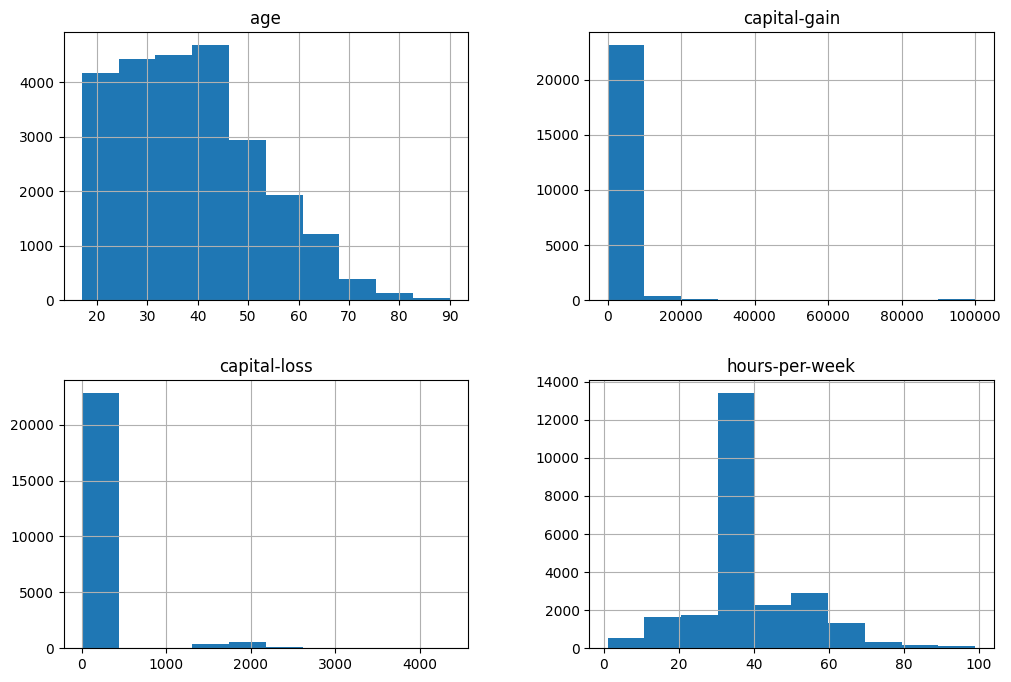

In [331]:
X_train.hist(figsize=(12,8));
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [332]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [333]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [334]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [335]:
X_train['workclass'].value_counts(True).head(1)

Private    0.696766
Name: workclass, dtype: float64

In [336]:
X_train['education'].value_counts(True).head(1)

HS-grad    0.322484
Name: education, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [337]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [338]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [339]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [340]:
X_train[categorical_features].head()
X_train[categorical_features].describe(include='all').T

,count,unique,top,freq
workclass,24420,9,Private,17378
education,24420,16,HS-grad,8537
marital-status,24420,7,Married-civ-spouse,11297
occupation,24420,15,Prof-specialty,3114
relationship,24420,6,Husband,9966
race,24420,5,White,20816
sex,24420,2,Male,16322
native-country,24420,42,United-States,21827


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [341]:
from sklearn.preprocessing import LabelEncoder

In [342]:
label_encoder = LabelEncoder()

In [343]:
X_train_le = X_train.copy()

In [344]:
X_test_le = X_test.copy()

In [345]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [346]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [347]:
X_test_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,4,15,0,1,1,4,0,0.0,0.0,38,39
1,45,7,11,2,4,5,4,0,0.0,0.0,40,39
2,29,4,9,2,4,0,2,1,0.0,0.0,55,39
3,30,4,9,4,7,1,4,0,0.0,0.0,40,39
4,29,6,15,0,3,1,4,1,2202.0,0.0,50,39


In [348]:
from sklearn.preprocessing import OneHotEncoder

In [349]:
onehot_encoder = OneHotEncoder()

In [350]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [351]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [352]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [353]:
X_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [354]:
X_test_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,27,0.0,0.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,45,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,0.0,0.0,55,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,29,2202.0,0.0,50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [355]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [356]:
linear_model_oh = LogisticRegression()

In [357]:
linear_model_le= LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [358]:
a_model=linear_model_oh.fit(X_train_new, y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [359]:
b_model=linear_model_le.fit(X_train_le, y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Валидация модели на тестовой выборке

In [360]:
prediction_oh = a_model.predict(X_test_new)

In [361]:
prediction_le=b_model.predict(X_test_le)

In [362]:
np.unique(prediction_oh)

array([0, 1])

In [363]:
np.unique(prediction_le)

array([0, 1])

In [364]:
# Сколько 1го класса присутсвует в предсказаниях?
prediction_oh.sum()

1580

In [365]:
prediction_le.sum()

793

In [366]:
# Сколько 1го класса присутсвует в y_test?
y_test.sum()

1927

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [367]:
from sklearn.metrics import accuracy_score

In [368]:
acc_oh = accuracy_score(y_test, prediction_oh)
acc_oh

0.8500184252548827

In [369]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [370]:
print('Accuracy Major Class: ', np.round(accuracy_score(y_test, np.zeros_like(y_test)),3))

Accuracy Major Class:  0.763


In [371]:
# Залогировать accuracy для LE
acc_le = accuracy_score(y_test, prediction_le)
acc_le

0.8054293084387667

In [372]:
experiment.log_metric('Accuracy OneHot data', acc_le)

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [373]:
from sklearn.metrics import confusion_matrix

In [374]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5777,437
1,784,1143


In [375]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=5c7b37288b824bf5bd2a2c5a2b4547ec&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=5c7b37288b824bf5bd2a2c5a2b4547ec&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'assetId': '5c7b37288b824bf5bd2a2c5a2b4547ec'}

## Прогноз вероятности принадлежности к классу

In [376]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [377]:
# Как выглядят предсказания?
pred_proba_oh 

array([[0.95191858, 0.04808142],
       [0.43128665, 0.56871335],
       [0.25623834, 0.74376166],
       ...,
       [0.99676377, 0.00323623],
       [0.37925458, 0.62074542],
       [0.67311284, 0.32688716]])

In [378]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'web': 'https://www.comet.com/api/image/download?imageId=d905368b62eb456a85e8adb8f749e9fd&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=d905368b62eb456a85e8adb8f749e9fd&experimentKey=7ef1143108ea40bd8095788f4bebca69',
 'imageId': 'd905368b62eb456a85e8adb8f749e9fd'}

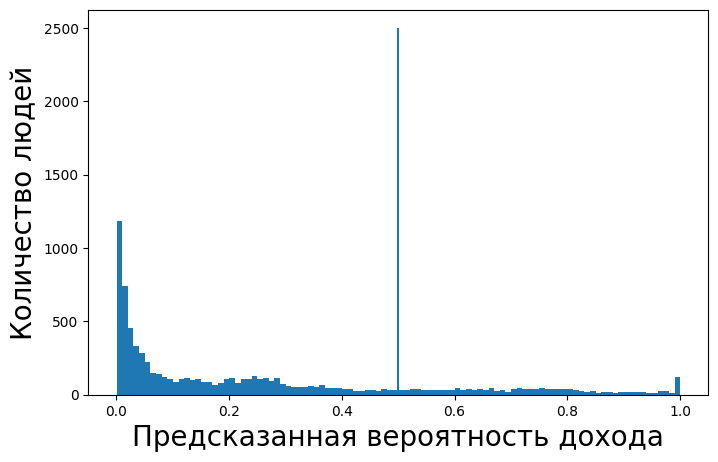

In [379]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [380]:
from sklearn.metrics import roc_curve

In [381]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

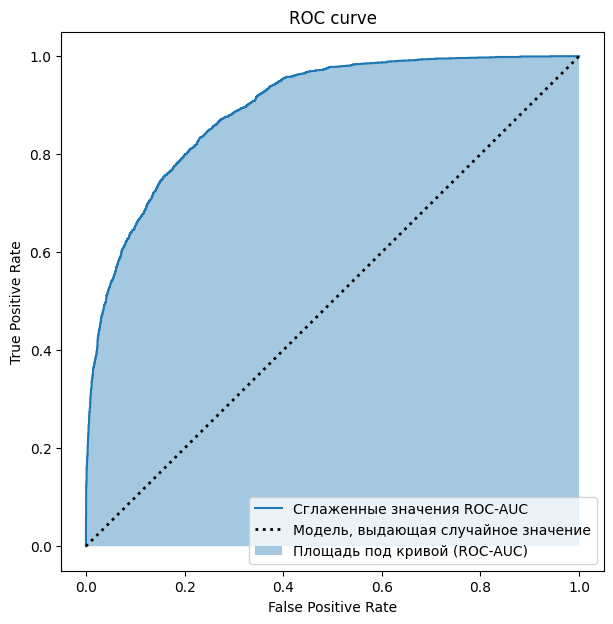

In [382]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [388]:
from sklearn.metrics import roc_auc_score

In [384]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [385]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.894


In [389]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [391]:
pred_proba_le =b_model.predict_proba(X_test_le)

In [396]:
pred_proba_2 = pred_proba_le[:, 1]

In [397]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc

0.784

In [398]:
false_positive_rates_1, true_positive_rates_1, threshold_1 = roc_curve(y_test, pred_proba_2)

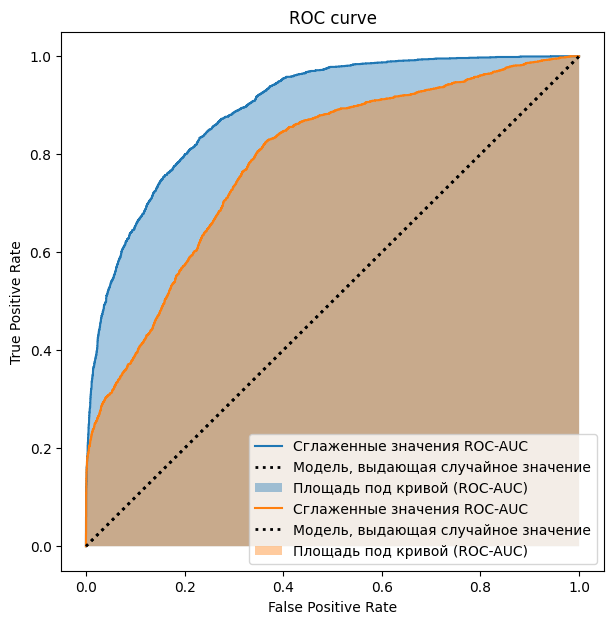

In [399]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')



# рисуем кривую
plt.plot(false_positive_rates_1, true_positive_rates_1, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates_1, true_positive_rates_1, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

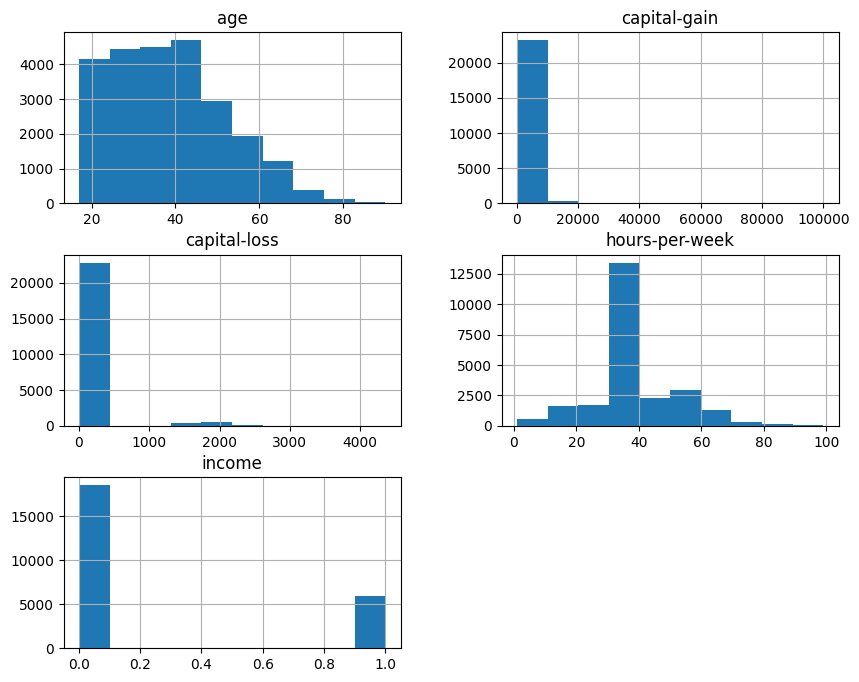

In [ ]:
training_data.hist(figsize=(10,8));

In [68]:
experiment.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x7ab660fbbf10>>